# Image classification with CNN
In this notebook we will experiment with classifying images of cats and dogs using Convolutional Neural Networks. 
The input dataset consists of 10,000 images manually labeled as ''cats'' and ''dogs''. This is the same dataset as in the logistic regression demo [folder](https://drive.google.com/file/d/1rjv0hlg6dcn0vMByikYfWpqpkk2vxtXA/view?usp=sharing). The preprocessing is the same as before.

## 1. Data preprocessing
Exactly the same as before.

### Import all the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from keras import preprocessing

import sys
import os

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

### Load images

In [2]:
cwd = os.getcwd()
os.chdir(cwd)

data_dir = "../data_sets/cat_dog_data"
print(os.listdir(data_dir))

['test_set', 'training_set']


In [3]:
train_cats_files = []
train_path_cats = data_dir +"/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        train_cats_files.append(os.path.join(train_path_cats, path))
        
train_dogs_files = []
train_path_dogs = data_dir +"/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        train_dogs_files.append(os.path.join(train_path_dogs, path))
        
print(len(train_cats_files), len(train_dogs_files))

test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if ".jpg" in path:
        test_cats_files.append(os.path.join(test_path_cats,path))

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))

print(len(test_cats_files), len(test_dogs_files))

4000 4000
1000 1000


In [4]:
k = 120
sample_dog_file = train_dogs_files[k]
img = preprocessing.image.load_img(sample_dog_file, target_size=(64, 64))
img_array = preprocessing.image.img_to_array(img)

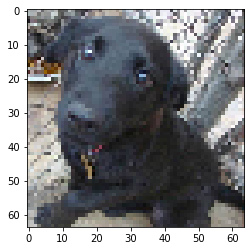

In [5]:
plt.imshow(np.uint8(img_array))

### Converting images to numpy arrays
Now we create training and testing sets for cats and for dogs and then concatenate them into a single `X_train`, `X_test` dataset of features.

In [6]:
d = 64
X_train_orig = np.zeros((8000, d, d, 3), dtype='float32')
for i in range(4000):    
    path = train_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)

for i in range(4000,8000):    
    path = train_dogs_files[i-4000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)    

    X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')

for i in range(1000):
    img = preprocessing.image.load_img(test_cats_files[i], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)
    
for i in range(1000, 2000):
    img = preprocessing.image.load_img(test_dogs_files[i-1000], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

print(X_train_orig.shape)
print(X_test_orig.shape)

(8000, 64, 64, 3)
(2000, 64, 64, 3)


### Normalizing image array

In [7]:
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0
print(X_train.shape)
print(X_test.shape)

(8000, 64, 64, 3)
(2000, 64, 64, 3)


### Adding class labels
Now we need to create the corresponding class label vectors. We will mark the cats as class 1, and the dogs as class 0 (not cats).

In [8]:
# class labels for train data

Y_train_orig = np.ones((4000,)) # 1 - 4000 are cat pictures so our label is 1
Y_train_orig = np.concatenate((Y_train_orig, np.zeros((4000,)))) # 4000 - 8000 are dog pictures so our label is 0

print(Y_train_orig)

Y_train = Y_train_orig.reshape(-1)
print(Y_train)
print("At position 3 should be a cat:", Y_train[3])
print("At position 4002 should be a dog:", Y_train[4002])
Y_train.shape

[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
At position 3 should be a cat: 1.0
At position 4002 should be a dog: 0.0


(8000,)

### Repeating the same steps for the test set

In [9]:
test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if '.jpg' in path:
        test_cats_files.append(os.path.join(test_path_cats, path))
        

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))
        

len(test_cats_files), len(test_dogs_files)

(1000, 1000)

In [10]:
X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')  

for i in range(1000):    
    path = test_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

for i in range(1000,2000):    
    path = test_dogs_files[i-1000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)    


X_test_orig.shape

(2000, 64, 64, 3)

In [11]:
# normalize test data
X_test = X_test_orig / 255.0

In [12]:
# create class label for test set
Y_test_orig = np.ones((1000,)) # 1 - 1000 are cat so label = 1
Y_test_orig = np.concatenate((Y_test_orig, np.zeros((1000,)))) # 1000 - 2000 are dog so label = 0

Y_test = Y_test_orig.reshape(-1)
Y_test.shape

(2000,)

## 2. Experimenting with CNN architectures

In this section, we develop a baseline convolutional neural network architecture for the dogs vs. cats dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf).

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these two layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices. For example, a 3-block VGG-style architecture where each block has a single convolutional and pooling layer can be defined in Keras as follows:

## Experiment 1. Baseline 1-block VGG-style network
Convolutional block:
- One Convolution layer 
- Max Pool

The last three layers before output stay the same thoughout all the experiments:
- Flatten: to combine all the filters into a single layer
- Dense
- Dense output layer with a single neuron: activation function is sigmoid  (we  predict a single class cat - not cat)

In [13]:
epochs = 10  
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.001, momentum=0.9) 

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                 padding='same', input_shape=(d, d, 3)))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model, asking also to keep track of accuracy at different iterations
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
history = model.fit(X_train, Y_train, epochs = epochs, verbose=True, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)

Epoch 1/10
63/63 [==============================] - 8s 126ms/step - loss: 0.6798 - accuracy: 0.5670 - val_loss: 0.6468 - val_accuracy: 0.6105
Epoch 2/10
63/63 [==============================] - 8s 121ms/step - loss: 0.6507 - accuracy: 0.6111 - val_loss: 0.6540 - val_accuracy: 0.5930
Epoch 3/10
63/63 [==============================] - 8s 123ms/step - loss: 0.6278 - accuracy: 0.6344 - val_loss: 0.6492 - val_accuracy: 0.6245
Epoch 4/10
63/63 [==============================] - 8s 121ms/step - loss: 0.6192 - accuracy: 0.6444 - val_loss: 0.6143 - val_accuracy: 0.6575
Epoch 5/10
63/63 [==============================] - 8s 122ms/step - loss: 0.6019 - accuracy: 0.6636 - val_loss: 0.6488 - val_accuracy: 0.6305
Epoch 6/10
63/63 [==============================] - 8s 131ms/step - loss: 0.5956 - accuracy: 0.6719 - val_loss: 0.6531 - val_accuracy: 0.6060
Epoch 7/10
63/63 [==============================] - 8s 131ms/step - loss: 0.6159 - accuracy: 0.6489 - val_loss: 0.6018 - val_accuracy: 0.6710
Epoch 

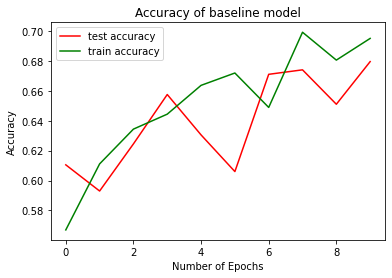

In [14]:
plt.plot(history.history['val_accuracy'], color='r', label="test accuracy")
plt.plot(history.history['accuracy'], color='g', label="train accuracy")

plt.title("Accuracy of baseline model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

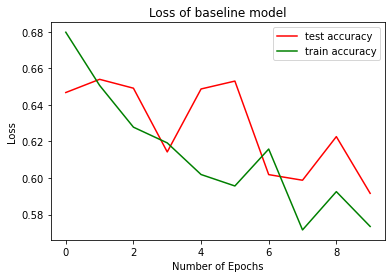

In [15]:
plt.plot(history.history['val_loss'], color='r', label="test accuracy")
plt.plot(history.history['loss'], color='g', label="train accuracy")

plt.title("Loss of baseline model")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

## Experiments

Trying to improve the baseline model

### Using a different optimizer

In [16]:
def create_base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(d, d, 3)))
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
    
def train(model, epochs=10, batch_size=128, opt=None, learning_rate=0.001):    
    if opt is None:
        opt = SGD(lr=0.001, momentum=0.9) # default optimizer
    # Compile the model
    model.compile(optimizer = opt , loss = "binary_crossentropy", metrics=["accuracy"])

    # Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
    history = model.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)
    print("Max train accuracy:", max(history.history["accuracy"]))
    print("Max test accuracy:", max(history.history["val_accuracy"]))
    return history

def accuracy(history, title=""):
    plt.plot(history.history['val_accuracy'], color='r', label="test accuracy")
    plt.plot(history.history['accuracy'], color='g', label="train accuracy")
    
    plt.title("Accuracy" + title)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    
    plt.legend()
    plt.show()

def loss(history, title=""):
    plt.plot(history.history['val_loss'], color='r', label="test loss")
    plt.plot(history.history['loss'], color='g', label="train loss")
    
    plt.title("Loss (error)" + title)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    
    plt.legend()
    plt.show()    

#### Adam

In [17]:
model_1 = create_base_model()

# lr - learning rate, beta_1, beta_2 - additional parameters influencing gradient descent
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

history_1 = train(model_1, opt=optimizer)

Max train accuracy: 0.9341250061988831
Max test accuracy: 0.7204999923706055


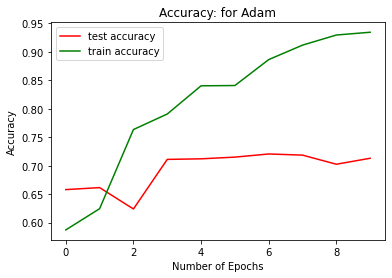

In [18]:
accuracy (history_1, ": for Adam")

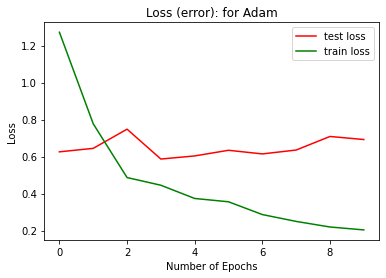

In [19]:
loss(history_1, ": for Adam")

#### RMSprop

In [20]:
model_2 = create_base_model()

# lr - learning rate
optimizer = RMSprop(lr=0.001)

history_2 = train(model_2, opt=optimizer)

Max train accuracy: 0.893750011920929
Max test accuracy: 0.7409999966621399


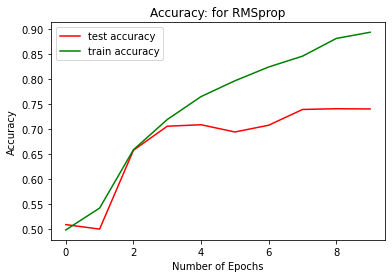

In [21]:
accuracy (history_2, ": for RMSprop")

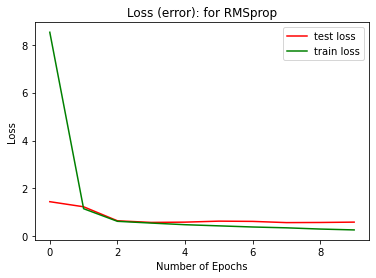

In [22]:
loss (history_2, ": for RMSprop")

Conclusion: RMSprop is the best out of 3 for this problem. Use __RMSprop__ in future experiments.

### Batch size
#### Increase?

In [23]:
model_3 = create_base_model()

# lr - learning rate
optimizer = RMSprop(lr=0.001)

history_3 = train(model_3, opt=optimizer, batch_size=256)

Max train accuracy: 0.6696249842643738
Max test accuracy: 0.6554999947547913


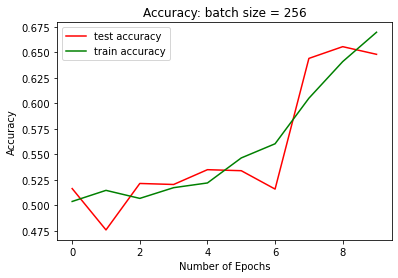

In [24]:
accuracy (history_3, ": batch size = 256")

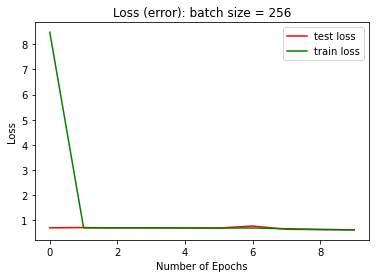

In [25]:
loss (history_3, ": batch size = 256")

#### Decrease?

In [26]:
model_4 = create_base_model()

# lr - learning rate
optimizer = RMSprop(lr=0.001)

history_4 = train(model_4, opt=optimizer, batch_size=64)

Max train accuracy: 0.9052500128746033
Max test accuracy: 0.7294999957084656


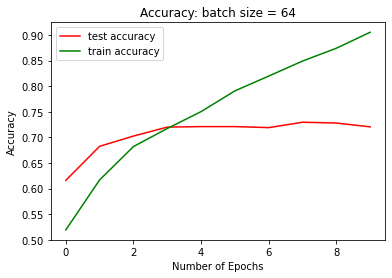

In [27]:
accuracy (history_4, ": batch size = 64")

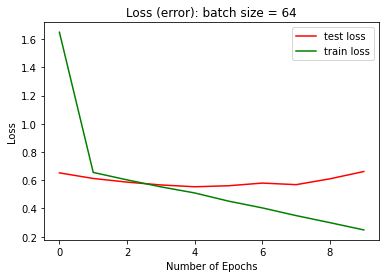

In [28]:
loss (history_4, ": batch size = 64")

Conclusion: we keep the batch_size = 128. __Model 2__ will serve as our base model.

### Learning rate
#### Increase?

In [29]:
model_5 = create_base_model()

# lr - learning rate originally was 0.001
optimizer = RMSprop(lr=0.005)

history_5 = train(model_5, opt=optimizer)

Max train accuracy: 0.9767500162124634
Max test accuracy: 0.6869999766349792


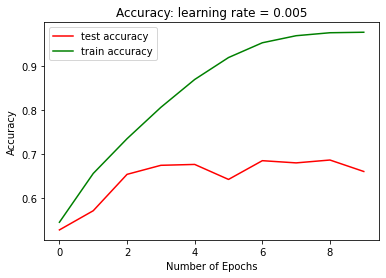

In [30]:
accuracy (history_5, ": learning rate = 0.005")

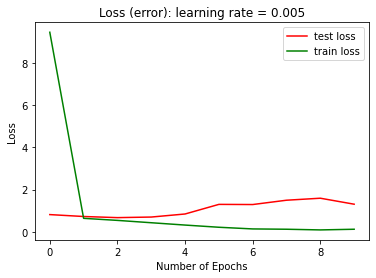

In [31]:
loss (history_5, ": learning rate = 0.005")

#### Decrease?

In [32]:
model_6 = create_base_model()

# lr - learning rate originally was 0.001
optimizer = RMSprop(lr=0.0005)

history_6 = train(model_6, opt=optimizer)

Max train accuracy: 0.8514999747276306
Max test accuracy: 0.7300000190734863


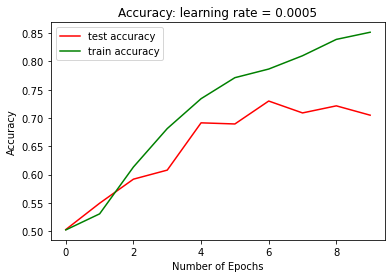

In [33]:
accuracy (history_6, ": learning rate = 0.0005")

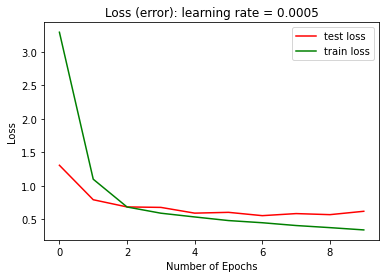

In [34]:
loss (history_6, ": learning rate = 0.0005")

#### Decrease even more?

In [35]:
model_7 = create_base_model()

# lr - learning rate originally was 0.001
optimizer = RMSprop(lr=0.00001)

history_7 = train(model_7, opt=optimizer)

Max train accuracy: 0.7103750109672546
Max test accuracy: 0.6919999718666077


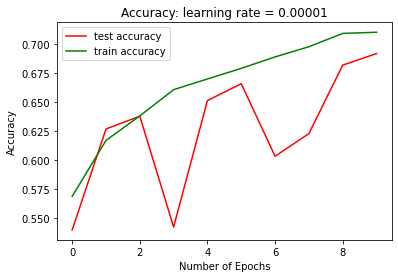

In [36]:
accuracy (history_7, ": learning rate = 0.00001")

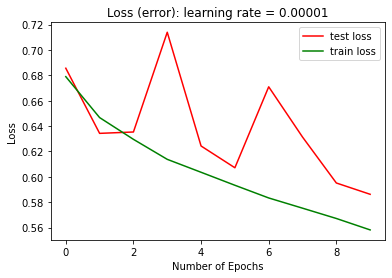

In [37]:
loss (history_7, ": learning rate = 0.00001")

Conclusion: the best learning rate is 0.0005. So we continue with __Model 6__.

### Increase number of epochs?

In [38]:
model_8 = create_base_model()

# lr - learning rate originally was 0.001
optimizer = RMSprop(lr=0.0005)

history_8 = train(model_8, opt=optimizer, epochs=20)

Max train accuracy: 0.9511250257492065
Max test accuracy: 0.7450000047683716


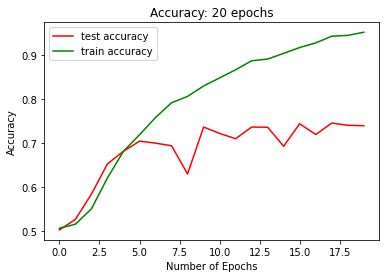

In [39]:
accuracy (history_8, ": 20 epochs")

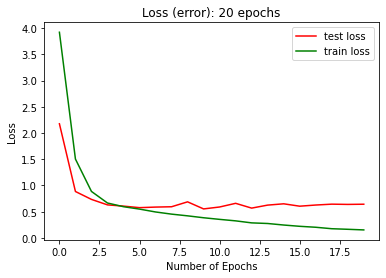

In [40]:
loss (history_8, ": 20 epochs")

It seems that after epoch 8 the base single-block model starts overfitting the train data. So we will keep number of epochs for the base model at 10. We continue with __Model 6__ and 10 epochs. 

### Adding dropout

In [41]:
def create_1_block_model_one_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(d, d, 3)))
    model.add(MaxPool2D((2, 2)))
    

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [42]:
model_9 = create_1_block_model_one_dropout()

# lr - learning rate originally was 0.001
optimizer = RMSprop(lr=0.0005)

history_9 = train(model_9, opt=optimizer, epochs=20)

Max train accuracy: 0.7864999771118164
Max test accuracy: 0.7264999747276306


No overfitting here, but the accuracy is significantly lower.

## Experiment 2. Two-block VGG-style network

Adding more convolutional layers.

Two layers of Convolutional filter pairs with max pooling after each pair.

Following the logic of the VGG paper, the number of filters should be doubled with each Convolutional block.

We will also rewrite the default parameters of learning according to the results of Experiment 1.

We also know that for deeper networks we need more time to train, and thus for the next series of experiments we will use number of epochs 20.

In [43]:
def create_2_block_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(d, d, 3)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def train_2(model, epochs=20, batch_size=128, opt=None, learning_rate=0.0005):    
    if opt is None:
        opt = RMSprop(lr=0.0005) # default optimizer
    # Compile the model
    model.compile(optimizer = opt , loss = "binary_crossentropy", metrics=["accuracy"])

    # Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
    history = model.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)
    print("Max train accuracy:", max(history.history["accuracy"]))
    print("Max test accuracy:", max(history.history["val_accuracy"]))
    return history

In [44]:
model_1_2 = create_2_block_model()

history_1_2 = train_2(model_1_2)

Max train accuracy: 0.9704999923706055
Max test accuracy: 0.777999997138977


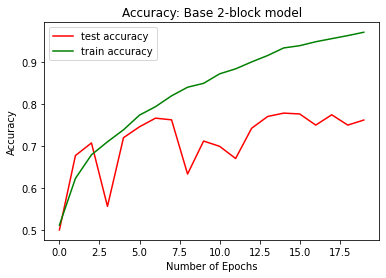

In [45]:
accuracy (history_1_2, ": Base 2-block model")

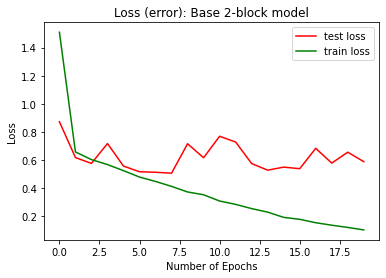

In [46]:
loss (history_1_2, ": Base 2-block model")

It is quite clear that the model with 2 blocks though more powerful tends to severely overfit the training data.

### One Dropout Layer
First we will try to add __one Dropout  layer before the output layer__.

In [47]:
def create_2_block_model_dropout1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(d, d, 3)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [48]:
model_2_2 = create_2_block_model_dropout1()

history_2_2 = train_2(model_2_2)

Max train accuracy: 0.8968750238418579
Max test accuracy: 0.7674999833106995


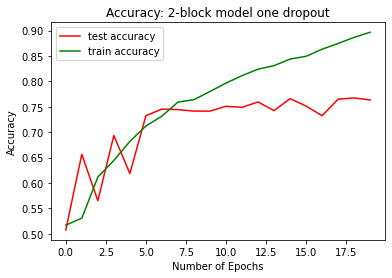

In [49]:
accuracy (history_2_2, ": 2-block model one dropout")

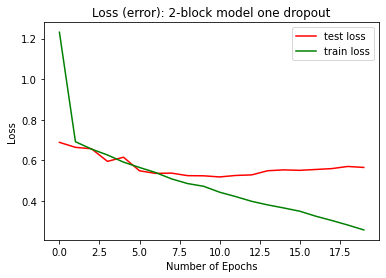

In [50]:
loss (history_2_2, ": 2-block model one dropout")

Now we are going to add a Dropout layer after each convolutional block.

### Adding Dropout everywhere

In [51]:
def create_2_block_model_with_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(d, d, 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [52]:
model_3_2 = create_2_block_model_with_dropout()

history_3_2 = train_2(model_3_2)

Max train accuracy: 0.7986249923706055
Max test accuracy: 0.7730000019073486


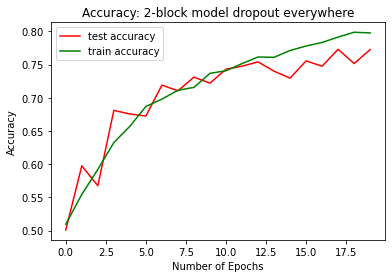

In [53]:
accuracy (history_3_2, ": 2-block model dropout everywhere")

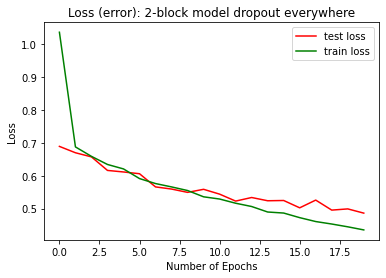

In [54]:
loss (history_3_2, ": 2-block model dropout everywhere")

The best  is model 3. It achieves about 75% accuracy and after 17 iterations the overfitting is still tolerable.
We keep model_3_2.

## Experiment 3. Three-block VGG-style network

3 Convolutional blocks, with max pooling and dropout after each of them. Using 30 epochs here.

In [55]:
def create_3_block_model_with_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(d, d, 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [56]:
model_1_3 = create_3_block_model_with_dropout()

history_1_3 = train_2(model_1_3, epochs=30)

Max train accuracy: 0.8857499957084656
Max test accuracy: 0.8084999918937683


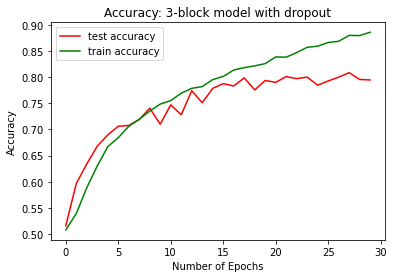

In [57]:
accuracy (history_1_3, ": 3-block model with dropout")

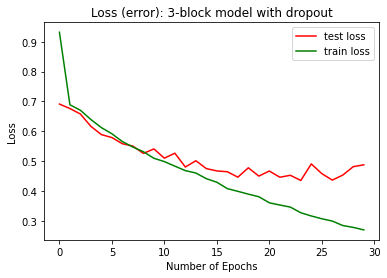

In [58]:
loss (history_1_3, ": 3-block model with dropout")

The winner so far is model_1_3. This is our best model with about 80% test accuracy.

The process of model improvement may continue for as long as we have ideas, time and resources to test them out. You can find more ideas in [this blog](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

## My cats and dogs: reality check

In [59]:
new_cats_path = "../data_sets/new_set/cats"
new_dogs_path = "../data_sets/new_set/dogs"

new_cats_files = []
new_dogs_files = []

for path in os.listdir(new_cats_path):
    if '.jpg' in path:
        new_cats_files.append(os.path.join(new_cats_path, path))
        
new_dogs_files = []
for path in os.listdir(new_dogs_path):
    if '.jpg' in path:
        new_dogs_files.append(os.path.join(new_dogs_path, path))
        
print(len(new_cats_files), len(new_dogs_files))

5 5


In [60]:
img_arr = np.zeros((10, d, d, 3), dtype='float32')
for i in range(5):    
    path = new_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    img_arr[i] = preprocessing.image.img_to_array(img)

for i in range(5,10):    
    path = new_dogs_files[i-5]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    img_arr[i] = preprocessing.image.img_to_array(img) 

In [61]:
X_all = img_arr / 255.0

print(X_all.shape)

(10, 64, 64, 3)


In [62]:
Y_predict_new_img = model_1_3.predict(X_all) 
print("predicted probabilities of classifying as cat:")
print("for cats:", Y_predict_new_img[0:5].tolist())
print("for dogs:", Y_predict_new_img[5:].tolist())

Y_labels = np.rint(Y_predict_new_img)

predicted probabilities of classifying as cat:
for cats: [[0.8729553818702698], [0.8273337483406067], [0.9411507248878479], [0.9988464713096619], [0.7061794400215149]]
for dogs: [[0.47516778111457825], [0.0006948411464691162], [0.7484526634216309], [0.6086965799331665], [0.6811679005622864]]


<Figure size 432x288 with 0 Axes>

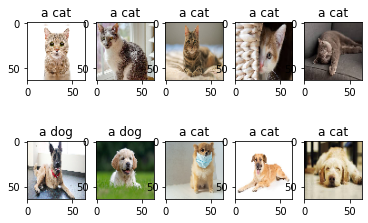

In [63]:
classes = ['dog','cat']

plt.figure()
f, axarr = plt.subplots(ncols=5, nrows=2) 

k = 0
for i in range(2):
    for j in range(5):
        axarr[i][j].imshow(np.uint8(img_arr[k]))      
        axarr[i][j].set_title("a "+ classes[int(Y_labels[k])])
        k += 1

Copyright &copy; 2022 Marina Barsky. All rights reserved.